 # Диагностика пневмонии с использованием DenseNet-121

**Автор**: Student  
**Датасет**: RSNA Pneumonia Detection Challenge  
**Модель**: DenseNet-121 с transfer learning  
**Цель**: Обучение модели для автоматической диагностики пневмонии по рентген-снимкам

## 1. Импорты и настройка окружения

In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 33.0 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm.auto import tqdm
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')

# Настройка для воспроизводимости
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Устройство для вычислений
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используемое устройство: {device}')

if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Доступная память: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')


Используемое устройство: cuda
GPU: Tesla T4
Доступная память: 14.7 GB


## 2. Загрузка и анализ данных RSNA

In [ ]:
from google.colab import files
import os
import json

print("📁 Загрузите ваш файл kaggle.json:")
print("(Если файла нет, следуйте инструкциям выше)")

# Загружаем файл kaggle.json
uploaded = files.upload()

# Проверяем, что файл загружен
if 'kaggle.json' in uploaded:
    print("✅ kaggle.json загружен успешно!")

    # Создаем папку для Kaggle API
    os.makedirs('/root/.kaggle', exist_ok=True)

    # Копируем и настраиваем права доступа
    !cp kaggle.json /root/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json

    # Проверяем содержимое (безопасно)
    with open('/root/.kaggle/kaggle.json', 'r') as f:
        config = json.load(f)
        print(f"🔑 API настроен для пользователя: {config['username']}")
else:
    print("❌ Файл kaggle.json не найден!")
    print("Пожалуйста, загрузите файл kaggle.json")

!pip install -q kaggle

!kaggle competitions download -c rsna-pneumonia-detection-challenge

import zipfile
import os
from tqdm import tqdm

def extract_with_progress(zip_path, extract_to):
    """Распаковка с прогресс-баром."""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        members = zip_ref.infolist()
        for member in tqdm(members, desc="Распаковка"):
            zip_ref.extract(member, extract_to)

print("📦 Распаковка датасета...")

# Создаем папку для данных
data_dir = '/content/rsna_data'
os.makedirs(data_dir, exist_ok=True)

# Распаковываем основной архив
zip_file = '/content/rsna-pneumonia-detection-challenge.zip'
if os.path.exists(zip_file):
    extract_with_progress(zip_file, data_dir)
    print("✅ Основной архив распакован")
else:
    print("❌ Архив не найден")

# Проверяем содержимое
print("\n📁 Содержимое датасета:")
for root, dirs, files in os.walk(data_dir):
    level = root.replace(data_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Показываем только первые 5 файлов
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... и еще {len(files) - 5} файлов")


📁 Загрузите ваш файл kaggle.json:
(Если файла нет, следуйте инструкциям выше)


Saving kaggle.json to kaggle.json
✅ kaggle.json загружен успешно!
🔑 API настроен для пользователя: cosmdandy
 98% 3.60G/3.66G [00:36<00:01, 37.8MB/s]
100% 3.66G/3.66G [00:36<00:00, 106MB/s] 
📦 Распаковка датасета...


Распаковка: 100%|██████████| 29688/29688 [00:44<00:00, 665.59it/s] 


✅ Основной архив распакован

📁 Содержимое датасета:
rsna_data/
  stage_2_sample_submission.csv
  GCP Credits Request Link - RSNA.txt
  stage_2_detailed_class_info.csv
  stage_2_train_labels.csv
  stage_2_train_images/
    d514ea44-ae23-4c0d-886f-a4f4cb909a9c.dcm
    a1055459-ab82-42b8-94f9-349a4ed5ec62.dcm
    b1831462-3f47-43e3-847a-e5c7db5cdd90.dcm
    93ff10c2-d08d-4c5c-85d4-ea61818995b9.dcm
    c20bbbc0-b770-4199-af48-4c63a48dce6d.dcm
    ... и еще 26679 файлов
  stage_2_test_images/
    265fc72c-f5f5-41bb-ac15-7ced161736df.dcm
    1e0c4ae9-52f0-4bec-827a-2824d13a1680.dcm
    1e367b6c-f5e6-43dc-8992-d97554c7f2fb.dcm
    14f199ad-e0d2-4360-a186-5aaaa652f3c7.dcm
    050b393e-4356-4eeb-9587-9a9b51da624e.dcm
    ... и еще 2995 файлов


In [ ]:
# %%
# Пути к данным (настроить для Kaggle)
DATA_DIR = '/content/rsna_data'
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, 'stage_2_train_images')
TEST_IMAGES_DIR = os.path.join(DATA_DIR, 'stage_2_test_images')

# Загрузка CSV файлов
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
train_detailed = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_detailed_class_info.csv'))

print("Структура данных:")
print(f"Размер train_labels: {train_labels.shape}")
print(f"Размер train_detailed: {train_detailed.shape}")

# Посмотрим на данные
print("\nПервые 5 строк train_labels:")
print(train_labels.head())

print("\nПервые 5 строк train_detailed:")
print(train_detailed.head())

Структура данных:
Размер train_labels: (30227, 6)
Размер train_detailed: (30227, 2)

Первые 5 строк train_labels:
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

Первые 5 строк train_detailed:
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4   

Распределение классов:
class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64


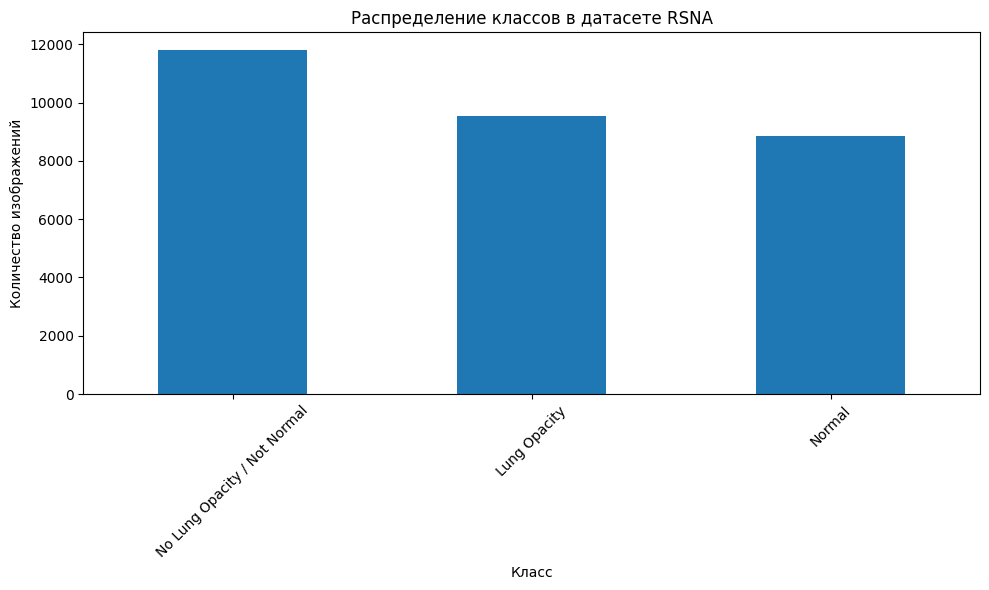

In [ ]:
# Анализ распределения классов в detailed данных
class_distribution = train_detailed['class'].value_counts()
print("Распределение классов:")
print(class_distribution)

# Визуализация распределения
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Распределение классов в датасете RSNA')
plt.xlabel('Класс')
plt.ylabel('Количество изображений')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Бинарное распределение:
0 (Normal):  20672
1 (Pneumonia):  9555
Соотношение: 0.462


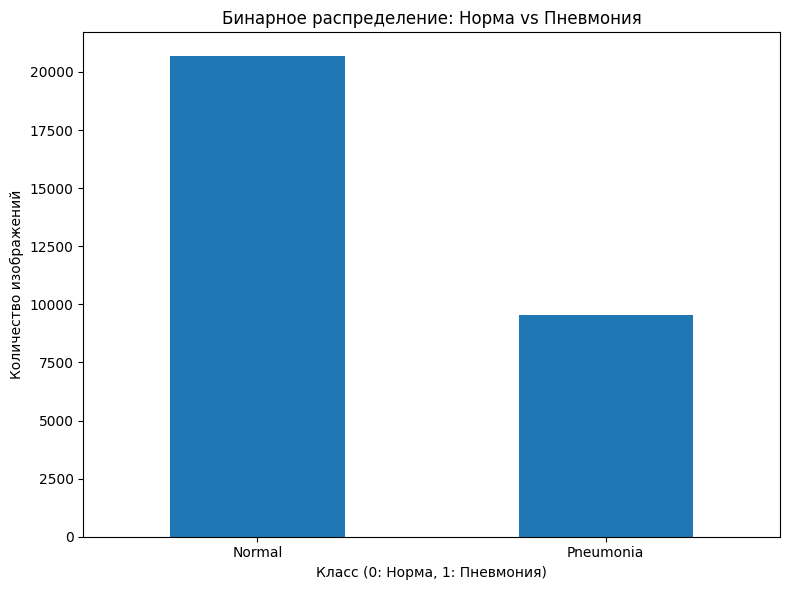

In [ ]:
# Подготовка данных для бинарной классификации
# Объединим Normal и No Lung Opacity как класс 0 (нет пневмонии)
# Lung Opacity как класс 1 (пневмония)

def prepare_binary_labels(detailed_df):
    """Подготовка меток для бинарной классификации."""
    binary_df = detailed_df.copy()

    # Переводим в бинарные метки
    binary_df['binary_label'] = (binary_df['class'] == 'Lung Opacity').astype(int)

    return binary_df

binary_data = prepare_binary_labels(train_detailed)

# Анализ бинарного распределения
binary_distribution = binary_data['binary_label'].value_counts()
print("Бинарное распределение:")
print("0 (Normal): ", binary_distribution[0])
print("1 (Pneumonia): ", binary_distribution[1])
print(f"Соотношение: {binary_distribution[1] / binary_distribution[0]:.3f}")

# Визуализация
plt.figure(figsize=(8, 6))
binary_distribution.plot(kind='bar')
plt.title('Бинарное распределение: Норма vs Пневмония')
plt.xlabel('Класс (0: Норма, 1: Пневмония)')
plt.ylabel('Количество изображений')
plt.xticks([0, 1], ['Normal', 'Pneumonia'], rotation=0)
plt.tight_layout()
plt.show()

## 3. Создание Dataset класса

In [ ]:
class RSNADataset(Dataset):
    """Dataset класс для загрузки рентген-изображений RSNA."""

    def __init__(self, dataframe, images_dir, transform=None, image_size=224):
        self.dataframe = dataframe.reset_index(drop=True)
        self.images_dir = images_dir
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Загрузка изображения
        image_id = row['patientId']
        image_path = os.path.join(self.images_dir, f"{image_id}.dcm")

        try:
            # Загрузка DICOM изображения
            import pydicom
            dicom = pydicom.dcmread(image_path)
            image = dicom.pixel_array

            # Нормализация в диапазон 0-255
            image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)

            # Конвертация в RGB
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        except Exception as e:
            print(f"Ошибка загрузки изображения {image_id}: {e}")
            # Создаем пустое изображение в случае ошибки
            image = np.zeros((self.image_size, self.image_size, 3), dtype=np.uint8)

        # Применяем трансформации
        if self.transform:
            image = self.transform(image)

        # Получаем метку
        label = torch.tensor(row['binary_label'], dtype=torch.float32)

        return image, label

In [ ]:
# Константы для нормализации ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Трансформации для обучения
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Трансформации для валидации
val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("Трансформации созданы успешно")

Трансформации созданы успешно


## 4. Разделение данных и создание DataLoader'ов

In [ ]:
# Разделение данных на train/val/test
train_data, temp_data = train_test_split(
    binary_data,
    test_size=0.3,
    random_state=42,
    stratify=binary_data['binary_label']
)

val_data, test_data = train_test_split(
    temp_data,
    test_size=0.5,
    random_state=42,
    stratify=temp_data['binary_label']
)

print(f"Размеры наборов данных:")
print(f"Train: {len(train_data)} ({len(train_data)/len(binary_data)*100:.1f}%)")
print(f"Validation: {len(val_data)} ({len(val_data)/len(binary_data)*100:.1f}%)")
print(f"Test: {len(test_data)} ({len(test_data)/len(binary_data)*100:.1f}%)")

# Проверим распределение классов в каждом наборе
for name, data in [("Train", train_data), ("Validation", val_data), ("Test", test_data)]:
    distribution = data['binary_label'].value_counts()
    print(f"\n{name} - распределение классов:")
    print(f"  Normal: {distribution[0]} ({distribution[0]/len(data)*100:.1f}%)")
    print(f"  Pneumonia: {distribution[1]} ({distribution[1]/len(data)*100:.1f}%)")

Размеры наборов данных:
Train: 21158 (70.0%)
Validation: 4534 (15.0%)
Test: 4535 (15.0%)

Train - распределение классов:
  Normal: 14470 (68.4%)
  Pneumonia: 6688 (31.6%)

Validation - распределение классов:
  Normal: 3101 (68.4%)
  Pneumonia: 1433 (31.6%)

Test - распределение классов:
  Normal: 3101 (68.4%)
  Pneumonia: 1434 (31.6%)


In [ ]:
# Создание Dataset объектов
train_dataset = RSNADataset(train_data, TRAIN_IMAGES_DIR, transform=train_transforms)
val_dataset = RSNADataset(val_data, TRAIN_IMAGES_DIR, transform=val_transforms)
test_dataset = RSNADataset(test_data, TRAIN_IMAGES_DIR, transform=val_transforms)

# Параметры для DataLoader
BATCH_SIZE = 16  # Уменьшено для экономии памяти
NUM_WORKERS = 2

# Создание DataLoader'ов
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"DataLoader'ы созданы:")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

DataLoader'ы созданы:
Train batches: 1323
Validation batches: 284
Test batches: 284


Размер батча изображений: torch.Size([16, 3, 224, 224])
Размер батча меток: torch.Size([16])
Тип данных изображений: torch.float32
Тип данных меток: torch.float32
Распределение меток в батче: 0.062


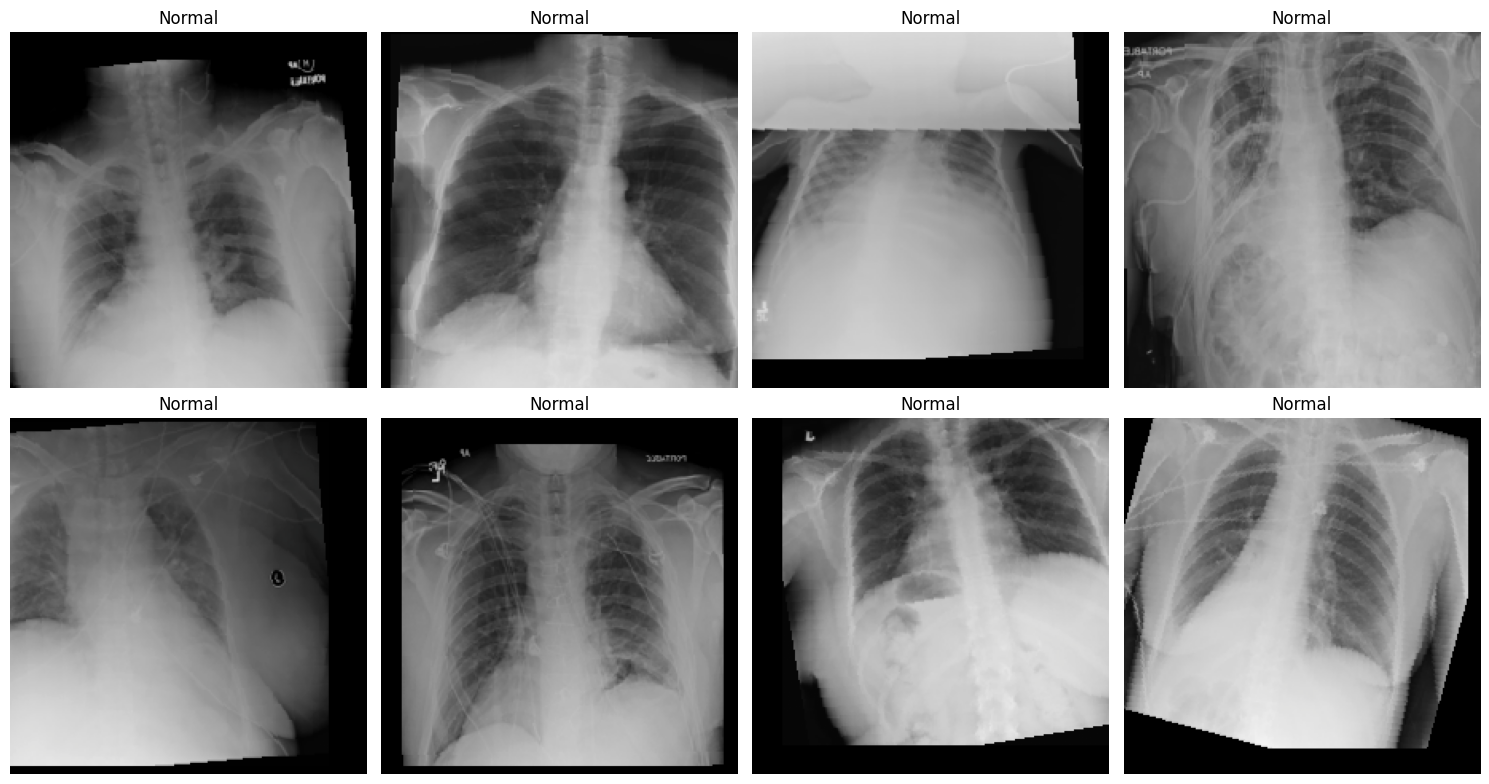

In [ ]:
# Тестируем загрузку данных
try:
    sample_batch = next(iter(train_loader))
    images, labels = sample_batch
    print(f"Размер батча изображений: {images.shape}")
    print(f"Размер батча меток: {labels.shape}")
    print(f"Тип данных изображений: {images.dtype}")
    print(f"Тип данных меток: {labels.dtype}")
    print(f"Распределение меток в батче: {labels.mean().item():.3f}")

    # Визуализация примеров
    plt.figure(figsize=(15, 8))
    for i in range(min(8, len(images))):
        plt.subplot(2, 4, i+1)

        # Денормализация для отображения
        img = images[i].clone()
        for t, m, s in zip(img, IMAGENET_MEAN, IMAGENET_STD):
            t.mul_(s).add_(m)
        img = torch.clamp(img, 0, 1)

        plt.imshow(img.permute(1, 2, 0))
        label_text = "Pneumonia" if labels[i].item() > 0.5 else "Normal"
        plt.title(f"{label_text}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Ошибка при тестировании загрузки данных: {e}")

## 5. Создание модели DenseNet-121

In [ ]:
class PneumoniaClassifier(nn.Module):
    """Классификатор пневмонии на основе DenseNet-121."""

    def __init__(self, num_classes=1, pretrained=True, dropout_rate=0.2):
        super(PneumoniaClassifier, self).__init__()

        # Загружаем предобученную DenseNet-121
        self.densenet = models.densenet121(pretrained=pretrained)

        # Заменяем классификатор
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, num_classes),
            nn.Sigmoid()  # Для бинарной классификации
        )

        # Замораживаем ранние слои для начала
        self._freeze_early_layers()

    def _freeze_early_layers(self):
        """Заморозка ранних слоев для transfer learning."""
        # Замораживаем features до denseblock3
        for name, param in self.densenet.named_parameters():
            if 'denseblock4' not in name and 'classifier' not in name:
                param.requires_grad = False

    def unfreeze_all_layers(self):
        """Разморозка всех слоев."""
        for param in self.densenet.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.densenet(x)

# Создание модели
model = PneumoniaClassifier(num_classes=1, pretrained=True, dropout_rate=0.2)
model = model.to(device)

# Подсчет параметров
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Общее количество параметров: {total_params:,}")
print(f"Обучаемые параметры: {trainable_params:,}")
print(f"Замороженные параметры: {total_params - trainable_params:,}")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 91.8MB/s]


Общее количество параметров: 6,954,881
Обучаемые параметры: 2,159,105
Замороженные параметры: 4,795,776


## 6. Настройка оптимизатора и функции потерь

In [ ]:
# Функция потерь
criterion = nn.BCELoss()

# Оптимизатор с разными learning rate для разных частей модели
optimizer = optim.Adam([
    {'params': model.densenet.features.parameters(), 'lr': 1e-4},  # Низкий LR для предобученных слоев
    {'params': model.densenet.classifier.parameters(), 'lr': 1e-3}  # Высокий LR для новых слоев
], weight_decay=1e-4)

# Планировщик learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

print("Оптимизатор и планировщик настроены")

Оптимизатор и планировщик настроены


## 7. Функции для обучения и валидации

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Обучение на одной эпохе."""
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch} - Training')

    for batch_idx, (inputs, labels) in enumerate(progress_bar):
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)  # Добавляем размерность для BCELoss

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        # Статистика
        running_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float()
        running_corrects += (preds == labels).sum().item()
        total_samples += labels.size(0)

        # Обновляем progress bar
        current_loss = running_loss / total_samples
        current_acc = running_corrects / total_samples
        progress_bar.set_postfix({
            'Loss': f'{current_loss:.4f}',
            'Acc': f'{current_acc:.4f}'
        })

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects / len(train_loader.dataset)

    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device, epoch):
    """Валидация на одной эпохе."""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    all_probs = []

    progress_bar = tqdm(val_loader, desc=f'Epoch {epoch} - Validation')

    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            # Прямой проход
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Статистика
            running_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            running_corrects += (preds == labels).sum().item()

            # Сохраняем для метрик
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
            all_probs.extend(outputs.cpu().numpy().flatten())

            # Обновляем progress bar
            current_loss = running_loss / (len(progress_bar.dataset) if hasattr(progress_bar, 'dataset') else len(val_loader.dataset))
            current_acc = running_corrects / (len(progress_bar.dataset) if hasattr(progress_bar, 'dataset') else len(val_loader.dataset))
            progress_bar.set_postfix({
                'Loss': f'{current_loss:.4f}',
                'Acc': f'{current_acc:.4f}'
            })

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects / len(val_loader.dataset)

    # Дополнительные метрики
    auc_roc = roc_auc_score(all_labels, all_probs)

    return epoch_loss, epoch_acc, auc_roc, all_preds, all_labels, all_probs

## 8. Основной цикл обучения

In [ ]:
# Параметры обучения
NUM_EPOCHS = 10  # Уменьшено для быстрого тестирования
EARLY_STOPPING_PATIENCE = 5
BEST_VAL_LOSS = float('inf')
PATIENCE_COUNTER = 0

# Списки для хранения истории обучения
train_losses = []
train_accs = []
val_losses = []
val_accs = []
val_aucs = []

print("Начинаем обучение...")
print(f"Устройство: {device}")
print(f"Количество эпох: {NUM_EPOCHS}")
print(f"Размер батча: {BATCH_SIZE}")

# Основной цикл обучения
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nЭпоха {epoch}/{NUM_EPOCHS}")
    print("-" * 50)

    # Обучение
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device, epoch
    )

    # Валидация
    val_loss, val_acc, val_auc, val_preds, val_labels, val_probs = validate_epoch(
        model, val_loader, criterion, device, epoch
    )

    # Сохраняем историю
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_aucs.append(val_auc)

    # Обновляем learning rate
    scheduler.step(val_loss)

    # Выводим результаты эпохи
    print(f"\nРезультаты эпохи {epoch}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")

    # Early stopping и сохранение лучшей модели
    if val_loss < BEST_VAL_LOSS:
        BEST_VAL_LOSS = val_loss
        PATIENCE_COUNTER = 0

        # Сохраняем лучшую модель
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_auc': val_auc,
            'metrics': {
                'accuracy': val_acc,
                'auc_roc': val_auc,
                'loss': val_loss
            }
        }, 'best_model.pth')

        print(f"✓ Новая лучшая модель сохранена (Val Loss: {val_loss:.4f})")
    else:
        PATIENCE_COUNTER += 1
        print(f"Без улучшения: {PATIENCE_COUNTER}/{EARLY_STOPPING_PATIENCE}")

    # Early stopping
    if PATIENCE_COUNTER >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping на эпохе {epoch}")
        break

    # Разморозка всех слоев после первых эпох
    if epoch == 3:
        print("Размораживаем все слои модели...")
        model.unfreeze_all_layers()

        # Обновляем оптимизатор с меньшим learning rate
        optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, verbose=True
        )

print("\nОбучение завершено!")

Начинаем обучение...
Устройство: cuda
Количество эпох: 10
Размер батча: 16

Эпоха 1/10
--------------------------------------------------


Epoch 1 - Validation: 100%|██████████| 284/284 [01:07<00:00,  4.20it/s, Loss=0.4076, Acc=0.8052]



Результаты эпохи 1:
Train Loss: 0.4439, Train Acc: 0.7927
Val Loss: 0.4076, Val Acc: 0.8052, Val AUC: 0.8790
✓ Новая лучшая модель сохранена (Val Loss: 0.4076)

Эпоха 2/10
--------------------------------------------------


Epoch 2 - Validation: 100%|██████████| 284/284 [01:07<00:00,  4.23it/s, Loss=0.3993, Acc=0.8176]



Результаты эпохи 2:
Train Loss: 0.4225, Train Acc: 0.8058
Val Loss: 0.3993, Val Acc: 0.8176, Val AUC: 0.8828
✓ Новая лучшая модель сохранена (Val Loss: 0.3993)

Эпоха 3/10
--------------------------------------------------


Epoch 3 - Validation: 100%|██████████| 284/284 [01:06<00:00,  4.27it/s, Loss=0.3865, Acc=0.8213]



Результаты эпохи 3:
Train Loss: 0.4111, Train Acc: 0.8131
Val Loss: 0.3865, Val Acc: 0.8213, Val AUC: 0.8880
✓ Новая лучшая модель сохранена (Val Loss: 0.3865)
Размораживаем все слои модели...

Эпоха 4/10
--------------------------------------------------


Epoch 4 - Validation: 100%|██████████| 284/284 [01:06<00:00,  4.29it/s, Loss=0.3824, Acc=0.8300]



Результаты эпохи 4:
Train Loss: 0.4108, Train Acc: 0.8134
Val Loss: 0.3824, Val Acc: 0.8300, Val AUC: 0.8955
✓ Новая лучшая модель сохранена (Val Loss: 0.3824)

Эпоха 5/10
--------------------------------------------------


Epoch 5 - Validation: 100%|██████████| 284/284 [01:06<00:00,  4.30it/s, Loss=0.3798, Acc=0.8277]



Результаты эпохи 5:
Train Loss: 0.3901, Train Acc: 0.8208
Val Loss: 0.3798, Val Acc: 0.8277, Val AUC: 0.8952
✓ Новая лучшая модель сохранена (Val Loss: 0.3798)

Эпоха 6/10
--------------------------------------------------


Epoch 6 - Validation: 100%|██████████| 284/284 [01:06<00:00,  4.29it/s, Loss=0.3748, Acc=0.8262]



Результаты эпохи 6:
Train Loss: 0.3795, Train Acc: 0.8285
Val Loss: 0.3748, Val Acc: 0.8262, Val AUC: 0.8979
✓ Новая лучшая модель сохранена (Val Loss: 0.3748)

Эпоха 7/10
--------------------------------------------------


Epoch 7 - Validation: 100%|██████████| 284/284 [01:06<00:00,  4.28it/s, Loss=0.3634, Acc=0.8333]



Результаты эпохи 7:
Train Loss: 0.3736, Train Acc: 0.8307
Val Loss: 0.3634, Val Acc: 0.8333, Val AUC: 0.9028
✓ Новая лучшая модель сохранена (Val Loss: 0.3634)

Эпоха 8/10
--------------------------------------------------


Epoch 8 - Validation: 100%|██████████| 284/284 [01:06<00:00,  4.26it/s, Loss=0.3743, Acc=0.8344]



Результаты эпохи 8:
Train Loss: 0.3687, Train Acc: 0.8336
Val Loss: 0.3743, Val Acc: 0.8344, Val AUC: 0.9006
Без улучшения: 1/5

Эпоха 9/10
--------------------------------------------------


Epoch 9 - Validation: 100%|██████████| 284/284 [01:06<00:00,  4.25it/s, Loss=0.3609, Acc=0.8381]



Результаты эпохи 9:
Train Loss: 0.3586, Train Acc: 0.8377
Val Loss: 0.3609, Val Acc: 0.8381, Val AUC: 0.9068
✓ Новая лучшая модель сохранена (Val Loss: 0.3609)

Эпоха 10/10
--------------------------------------------------


Epoch 10 - Validation: 100%|██████████| 284/284 [01:05<00:00,  4.31it/s, Loss=0.3664, Acc=0.8372]


Результаты эпохи 10:
Train Loss: 0.3550, Train Acc: 0.8385
Val Loss: 0.3664, Val Acc: 0.8372, Val AUC: 0.9044
Без улучшения: 1/5

Обучение завершено!


## 9. Визуализация результатов обучения

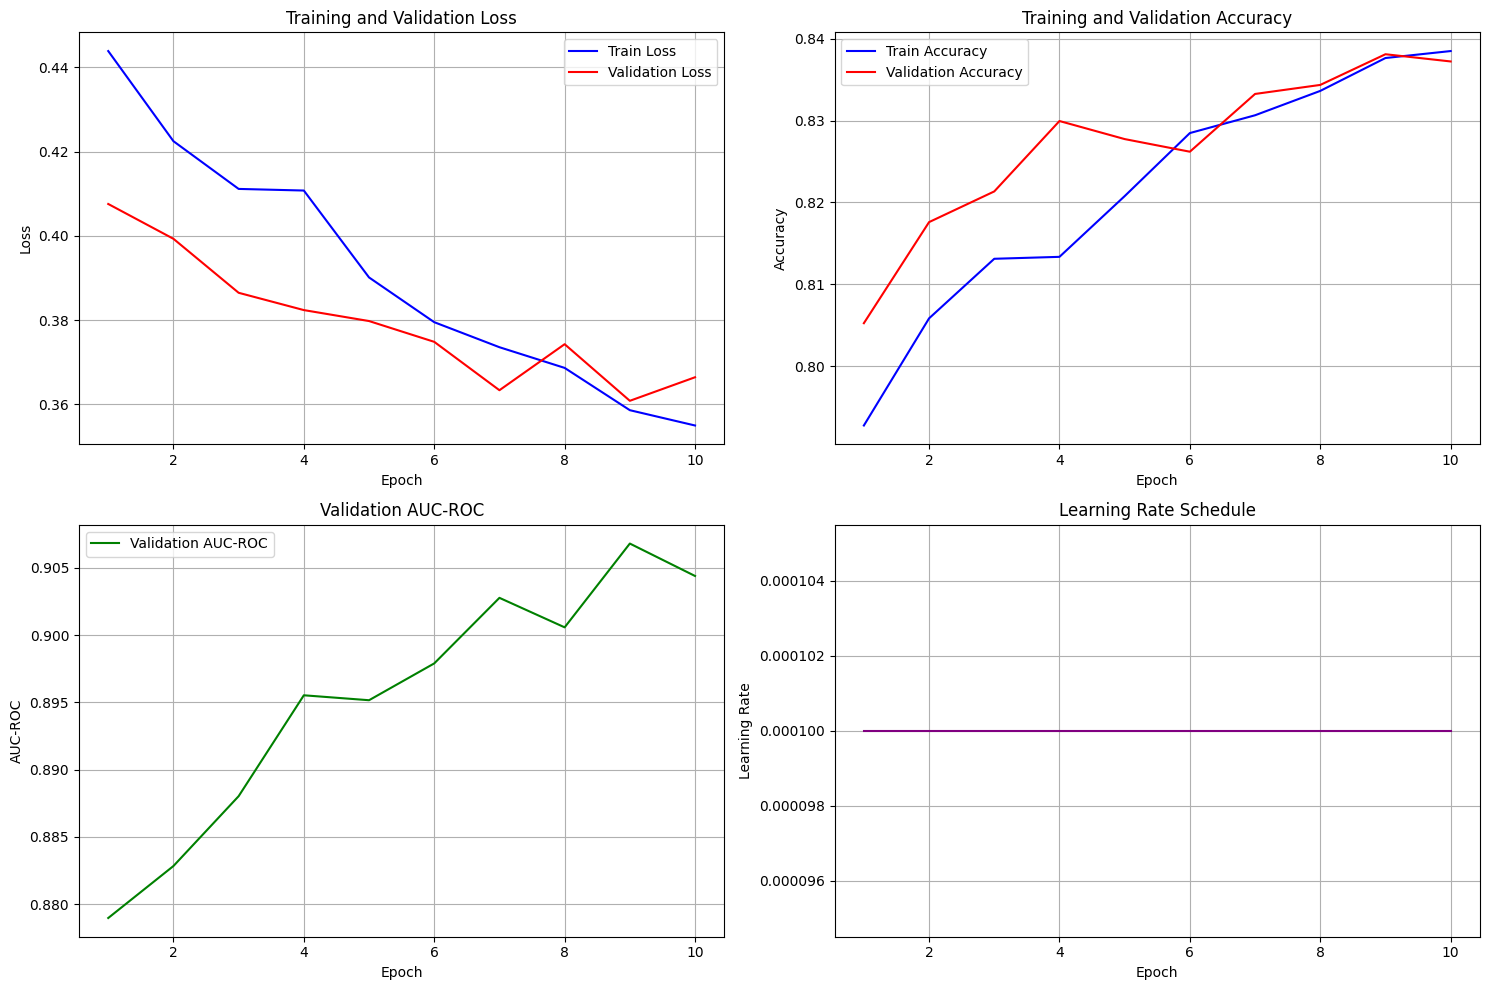


Финальные результаты:
Лучшая validation loss: 0.3609
Лучшая validation accuracy: 0.8381
Лучшая validation AUC-ROC: 0.9068


In [ ]:
# Построение графиков обучения
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# График потерь
axes[0, 0].plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss')
axes[0, 0].plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# График точности
axes[0, 1].plot(range(1, len(train_accs) + 1), train_accs, 'b-', label='Train Accuracy')
axes[0, 1].plot(range(1, len(val_accs) + 1), val_accs, 'r-', label='Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# График AUC-ROC
axes[1, 0].plot(range(1, len(val_aucs) + 1), val_aucs, 'g-', label='Validation AUC-ROC')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC-ROC')
axes[1, 0].set_title('Validation AUC-ROC')
axes[1, 0].legend()
axes[1, 0].grid(True)

# График learning rate (если доступно)
# Получаем текущий learning rate
lrs = [group['lr'] for group in optimizer.param_groups]
axes[1, 1].plot(range(1, len(train_losses) + 1), [lrs[0]] * len(train_losses), 'purple')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Вывод финальных метрик
print(f"\nФинальные результаты:")
print(f"Лучшая validation loss: {min(val_losses):.4f}")
print(f"Лучшая validation accuracy: {max(val_accs):.4f}")
print(f"Лучшая validation AUC-ROC: {max(val_aucs):.4f}")

## 10. Оценка на тестовой выборке

In [ ]:
# Загружаем лучшую модель
print("Загрузка лучшей модели для тестирования...")
checkpoint = torch.load('best_model.pth', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Загружена модель с эпохи {checkpoint['epoch']}")

# Оценка на тестовой выборке
model.eval()
test_preds = []
test_labels = []
test_probs = []

print("Оценка на тестовой выборке...")
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        # Собираем предсказания
        preds = (outputs > 0.5).float().cpu().numpy().flatten()
        probs = outputs.cpu().numpy().flatten()
        labels_np = labels.cpu().numpy().flatten()

        test_preds.extend(preds)
        test_labels.extend(labels_np)
        test_probs.extend(probs)

# Конвертируем в numpy arrays
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_probs = np.array(test_probs)

# Вычисляем метрики
test_accuracy = accuracy_score(test_labels, test_preds)
test_auc_roc = roc_auc_score(test_labels, test_probs)

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
tn, fp, fn, tp = cm.ravel()

# Дополнительные метрики
sensitivity = tp / (tp + fn)  # True Positive Rate
specificity = tn / (tn + fp)  # True Negative Rate
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

print(f"\nРезультаты на тестовой выборке:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"AUC-ROC: {test_auc_roc:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1_score:.4f}")

print(f"\nConfusion Matrix:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

Загрузка лучшей модели для тестирования...
Загружена модель с эпохи 9
Оценка на тестовой выборке...


Testing: 100%|██████████| 284/284 [01:09<00:00,  4.08it/s]


Результаты на тестовой выборке:
Accuracy: 0.8417
AUC-ROC: 0.9124
Sensitivity (Recall): 0.7183
Specificity: 0.8987
Precision: 0.7664
F1-Score: 0.7415

Confusion Matrix:
True Negatives: 2787
False Positives: 314
False Negatives: 404
True Positives: 1030


## 11. Визуализация результатов

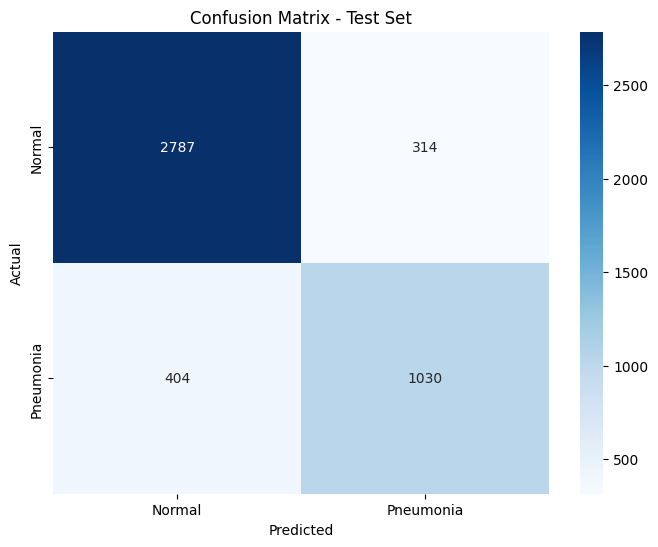

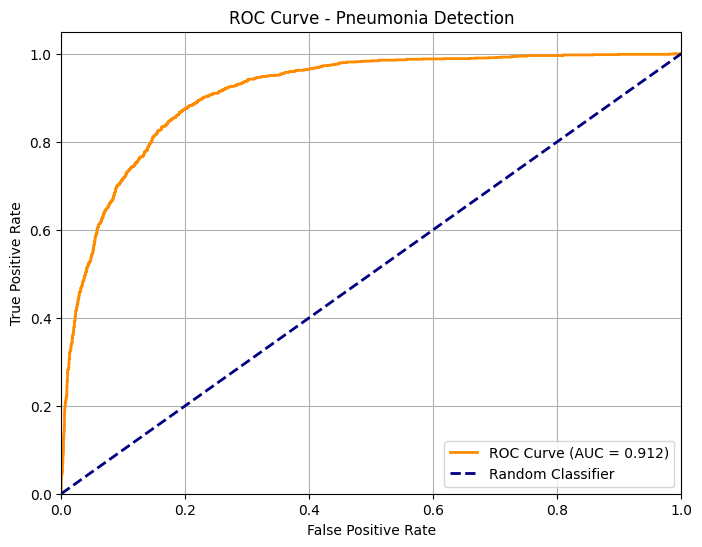

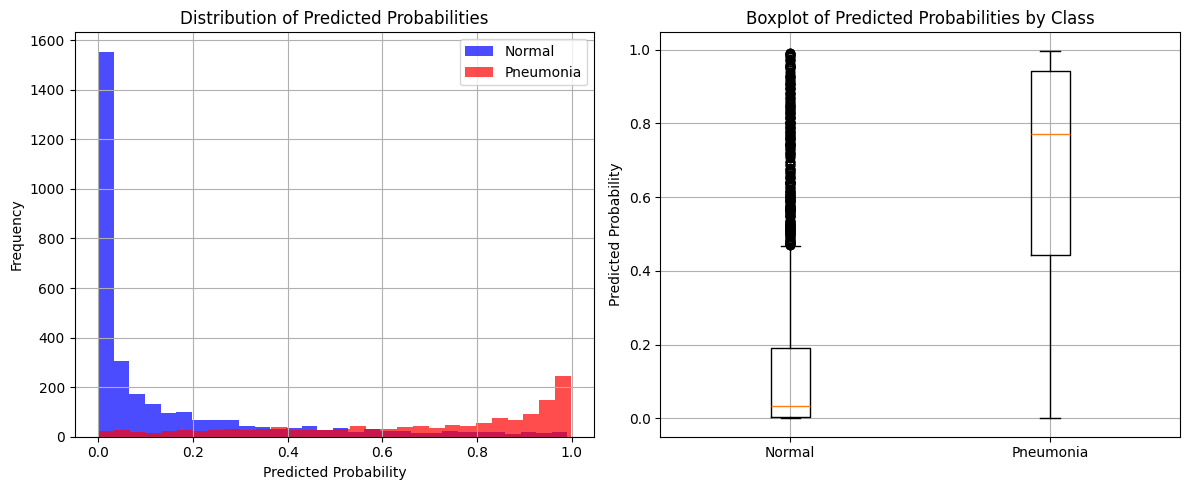

In [ ]:
# Построение Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Pneumonia Detection')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Distribution of predicted probabilities
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(test_probs[test_labels == 0], bins=30, alpha=0.7, label='Normal', color='blue')
plt.hist(test_probs[test_labels == 1], bins=30, alpha=0.7, label='Pneumonia', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot([test_probs[test_labels == 0], test_probs[test_labels == 1]],
           labels=['Normal', 'Pneumonia'])
plt.ylabel('Predicted Probability')
plt.title('Boxplot of Predicted Probabilities by Class')
plt.grid(True)

plt.tight_layout()
plt.show()

## 12. Сохранение финальной модели

In [ ]:
# Сохраняем финальную модель с подробной информацией
final_metrics = {
    'test_accuracy': test_accuracy,
    'test_auc_roc': test_auc_roc,
    'sensitivity': sensitivity,
    'specificity': specificity,
    'precision': precision,
    'f1_score': f1_score
}

torch.save({
    'model_state_dict': model.state_dict(),
    'metrics': final_metrics,
    'training_history': {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'val_aucs': val_aucs
    },
    'model_info': {
        'architecture': 'DenseNet-121',
        'num_classes': 1,
        'input_size': 224,
        'total_params': total_params,
        'trainable_params': trainable_params
    }
}, 'model_weights.pth')

print("Финальная модель сохранена как 'model_weights.pth'")

# Также создаем версию только с state_dict для простоты загрузки
torch.save(model.state_dict(), 'model_weights_state_dict.pth')
print("State dict сохранен как 'model_weights_state_dict.pth'")

Финальная модель сохранена как 'model_weights.pth'
State dict сохранен как 'model_weights_state_dict.pth'


## 13. Итоговый отчет

In [ ]:
print("\n" + "="*60)
print("ИТОГОВЫЙ ОТЧЕТ ОБУЧЕНИЯ МОДЕЛИ")
print("="*60)

print(f"\nАрхитектура модели: DenseNet-121")
print(f"Общее количество параметров: {total_params:,}")
print(f"Обучаемые параметры: {trainable_params:,}")

print(f"\nОбучающие данные:")
print(f"Размер обучающей выборки: {len(train_data):,}")
print(f"Размер валидационной выборки: {len(val_data):,}")
print(f"Размер тестовой выборки: {len(test_data):,}")

print(f"\nПараметры обучения:")
print(f"Количество эпох: {len(train_losses)}")
print(f"Размер батча: {BATCH_SIZE}")
print(f"Оптимизатор: Adam")
print(f"Функция потерь: Binary Cross Entropy")

print(f"\nФинальные результаты на тестовой выборке:")
print(f"Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"AUC-ROC: {test_auc_roc:.4f}")
print(f"Sensitivity: {sensitivity:.4f} ({sensitivity*100:.1f}%)")
print(f"Specificity: {specificity:.4f} ({specificity*100:.1f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.1f}%)")
print(f"F1-Score: {f1_score:.4f}")

print(f"\nМатрица ошибок:")
print(f"True Negatives: {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,}")
print(f"True Positives: {tp:,}")

print(f"\nФайлы модели:")
print(f"- model_weights.pth (полная модель с метриками)")
print(f"- model_weights_state_dict.pth (только веса)")

print("\n" + "="*60)
print("ОБУЧЕНИЕ ЗАВЕРШЕНО УСПЕШНО!")
print("="*60)


ИТОГОВЫЙ ОТЧЕТ ОБУЧЕНИЯ МОДЕЛИ

Архитектура модели: DenseNet-121
Общее количество параметров: 6,954,881
Обучаемые параметры: 2,159,105

Обучающие данные:
Размер обучающей выборки: 21,158
Размер валидационной выборки: 4,534
Размер тестовой выборки: 4,535

Параметры обучения:
Количество эпох: 10
Размер батча: 16
Оптимизатор: Adam
Функция потерь: Binary Cross Entropy

Финальные результаты на тестовой выборке:
Accuracy: 0.8417 (84.2%)
AUC-ROC: 0.9124
Sensitivity: 0.7183 (71.8%)
Specificity: 0.8987 (89.9%)
Precision: 0.7664 (76.6%)
F1-Score: 0.7415

Матрица ошибок:
True Negatives: 2,787
False Positives: 314
False Negatives: 404
True Positives: 1,030

Файлы модели:
- model_weights.pth (полная модель с метриками)
- model_weights_state_dict.pth (только веса)

ОБУЧЕНИЕ ЗАВЕРШЕНО УСПЕШНО!
